# classification-04

## What's new:

1- increase labels

## next step:

1- Improve labeling ( 3333 from 28-1111 )


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape, TimeDistributed, Lambda, RepeatVector
from tensorflow.keras import Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, callbacks
import talib


In [ ]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [ ]:
df.shape

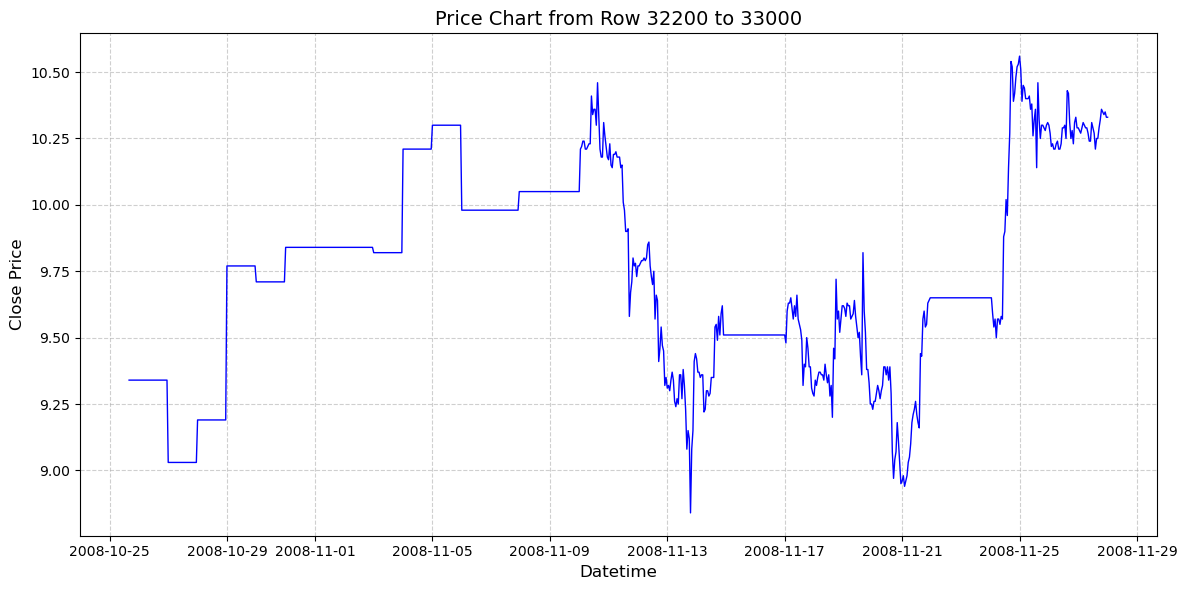

In [5]:
import matplotlib.pyplot as plt

# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [6]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [7]:
def label_reversal_points(prices, window=6, threshold=0.0007):
    """
    Labels trend reversals (1=Buy, 2=Sell) based on local mean shifts.
    Smaller window & threshold increase sensitivity.
    """
    prices = np.asarray(prices)
    labels = [0] * len(prices)
    prev_trend = 0  # 1 = up, -1 = down, 0 = unknown

    for i in range(len(prices) - window):
        past = prices[i:i + window // 2]
        future = prices[i + window // 2:i + window]

        past_mean = np.mean(past)
        future_mean = np.mean(future)
        change = (future_mean - past_mean) / past_mean

        if change > threshold:
            curr_trend = 1  # Uptrend
        elif change < -threshold:
            curr_trend = -1  # Downtrend
        else:
            curr_trend = 0  # No significant trend

        # Detect reversal only when trend flips clearly
        if prev_trend == -1 and curr_trend == 1:
            labels[i + window // 2] = 1  # Buy
        elif prev_trend == 1 and curr_trend == -1:
            labels[i + window // 2] = 2  # Sell

        if curr_trend != 0:
            prev_trend = curr_trend

    return labels


df_model['Label'] = label_reversal_points(df_model['CLOSE'].values)

In [8]:
print(df_model['Label'].value_counts().sort_index())  # 0, 1, 2

Label
0    130688
1      7834
2      7834
Name: count, dtype: int64


In [9]:
import matplotlib.pyplot as plt


def plot_labeled_candles(df, n=190):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



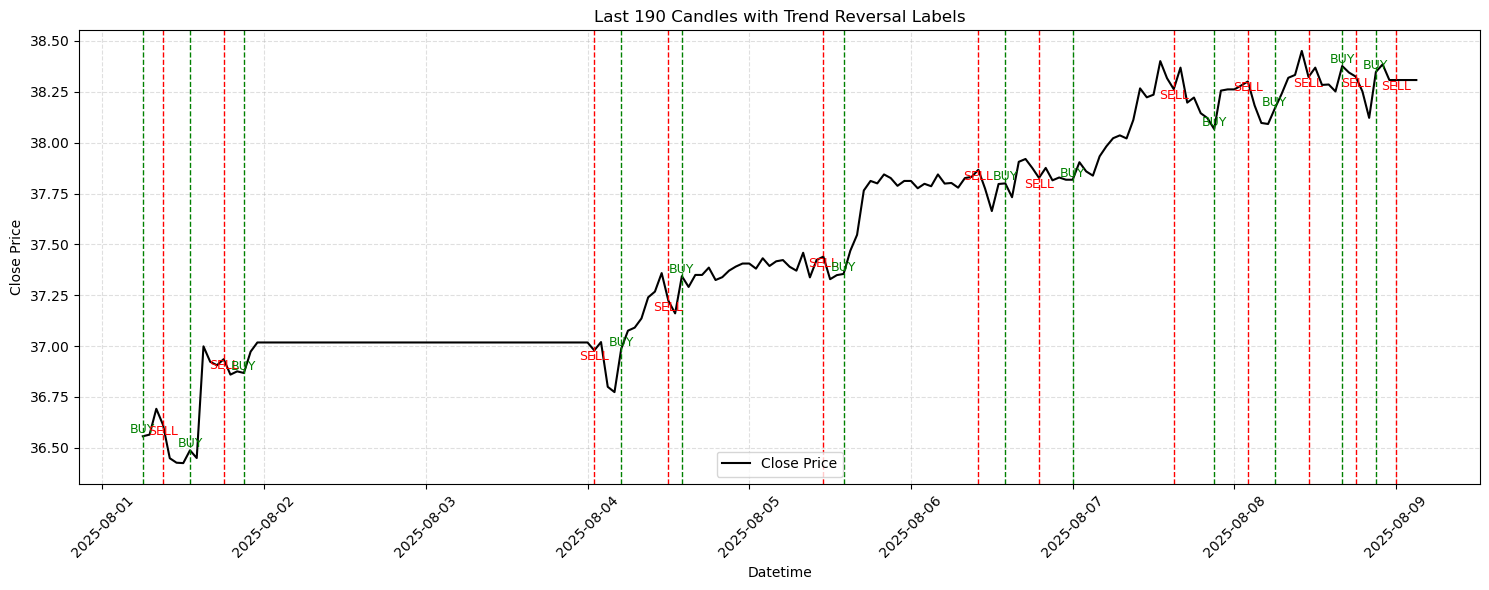

In [10]:
plot_labeled_candles(df_model)

In [11]:
from collections import Counter

# User parameters (you provided)
WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
NUM_CLASSES = 3  # 0,1,2

# Training hyperparameters (tweak as needed)
LEARNING_RATE = 1e-3
VALIDATION_SPLIT_RATIO = 0.1  # portion of training time-series reserved for validation after temporal split
TEST_SPLIT_RATIO = 0.1  # final hold-out test set (temporal)
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# === 0. Sanity checks + minimal preprocessing ===
# Assumes df_model exists in the workspace and has DATETIME (datetime-like) and Label columns
assert 'DATETIME' in df_model.columns, "df_model must already contain 'DATETIME' column"
assert 'Label' in df_model.columns, "df_model must already contain 'Label' column"

# Ensure DATETIME is datetime dtype and sorted
df_model['DATETIME'] = pd.to_datetime(df_model['DATETIME'])
df_model = df_model.sort_values('DATETIME').reset_index(drop=True)

# Optional: fill small NaNs in FEATURES if any (shouldn't be necessary if you've cleaned dataset)
df_model[FEATURES] = df_model[FEATURES].ffill().bfill()

# === 1. Add time features to help the model learn holidays/weekends/seasonality ===
# These are continuous/cyclical features — they let model learn patterns like weekends/holidays that
# are periodic in time. Since dataset is continuous (includes holidays), these help model detect those.
df_model['hour'] = df_model['DATETIME'].dt.hour
df_model['dow'] = df_model['DATETIME'].dt.weekday  # 0=Mon .. 6=Sun
df_model['dayofyear'] = df_model['DATETIME'].dt.dayofyear

# cyclical transforms
df_model['hour_sin'] = np.sin(2 * np.pi * df_model['hour'] / 24.0)
df_model['hour_cos'] = np.cos(2 * np.pi * df_model['hour'] / 24.0)
df_model['dow_sin'] = np.sin(2 * np.pi * df_model['dow'] / 7.0)
df_model['dow_cos'] = np.cos(2 * np.pi * df_model['dow'] / 7.0)
df_model['dayofyear_sin'] = np.sin(2 * np.pi * df_model['dayofyear'] / 365.25)
df_model['dayofyear_cos'] = np.cos(2 * np.pi * df_model['dayofyear'] / 365.25)

# Extend FEATURES to include these engineered time-features
ADDITIONAL = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofyear_sin', 'dayofyear_cos']
ALL_FEATURES = FEATURES + ADDITIONAL


# === 2. Create sliding windows and horizon labels ===
# For each time t we will create input X = rows [t-WINDOW_SIZE+1 ... t] (length WINDOW_SIZE)
# and label Y = Label at times [t+1 ... t+FORECAST_HORIZON] (the next FORECAST_HORIZON hours)
# We will discard windows that cannot produce a full horizon.

def make_windows_and_labels(df, feature_cols, label_col='Label',
                            window_size=WINDOW_SIZE, horizon=FORECAST_HORIZON):
    X_list = []
    y_list = []
    dt_index = []  # store the last timestamp of the input window (for later reference)
    n = len(df)
    # iterate t = index of last row in the input window
    for t in range(window_size - 1, n - horizon):
        x_block = df.iloc[t - (window_size - 1): t + 1][feature_cols].values  # shape (window_size, n_features)
        y_block = df.iloc[t + 1: t + 1 + horizon][label_col].astype(int).values  # shape (horizon,)
        X_list.append(x_block)
        y_list.append(y_block)
        dt_index.append(df['DATETIME'].iloc[t])  # last input timestamp
    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.int32)
    return X, y, np.array(dt_index)


X_all, y_all, dt_all = make_windows_and_labels(df_model, ALL_FEATURES, 'Label',
                                               window_size=WINDOW_SIZE, horizon=FORECAST_HORIZON)
print(f"Total samples created: {X_all.shape[0]}, X shape: {X_all.shape}, y shape: {y_all.shape}")

# === 3. Temporal train/val/test split (no leakage) ===
# We'll keep last TEST_SPLIT_RATIO of chronologically ordered samples as test set (hold-out).
n_samples = X_all.shape[0]
n_test = int(np.ceil(TEST_SPLIT_RATIO * n_samples))
n_trainval = n_samples - n_test

X_trainval = X_all[:n_trainval]
y_trainval = y_all[:n_trainval]
dt_trainval = dt_all[:n_trainval]

X_test = X_all[n_trainval:]
y_test = y_all[n_trainval:]
dt_test = dt_all[n_trainval:]

# Now split trainval into train and validation chronologically as well
n_val = int(np.ceil(VALIDATION_SPLIT_RATIO * X_trainval.shape[0]))
n_train = X_trainval.shape[0] - n_val

X_train = X_trainval[:n_train]
y_train = y_trainval[:n_train]
dt_train = dt_trainval[:n_train]

X_val = X_trainval[n_train:]
y_val = y_trainval[n_train:]
dt_val = dt_trainval[n_train:]

print("Train / Val / Test sizes:", X_train.shape[0], X_val.shape[0], X_test.shape[0])

from sklearn.preprocessing import StandardScaler

# === 4. Scale features: fit scaler on train only, apply to val/test ===
# scaler expects 2D, so we reshape windows to (n_samples * window_size, n_features) and inverse reshape
n_features = len(ALL_FEATURES)
scaler = StandardScaler()
X_train_2d = X_train.reshape(-1, n_features)
scaler.fit(X_train_2d)


def scale_windows(X, scaler):
    n_s, w, nf = X.shape
    X2 = X.reshape(-1, nf)
    X2 = scaler.transform(X2)
    return X2.reshape(n_s, w, nf)


X_train_s = scale_windows(X_train, scaler)
X_val_s = scale_windows(X_val, scaler)
X_test_s = scale_windows(X_test, scaler)


# === 5. Deal with class imbalance ===
# We'll produce:
#  - y_train_cat: one-hot categorical targets (n_samples, horizon, num_classes)
#  - sample_weight_train: per-sample-per-timestep weights (n_samples, horizon)
#
# Strategy:
#  - Compute global class frequencies across train set (across all timesteps in horizon)
#  - Set class_weight = total_samples / (num_classes * class_count)  (sklearn-style)
#  - Build sample_weights_train by mapping each (sample, timestep) label -> class_weight[label]
#  - Also lightly upsample windows that contain any non-zero label (i.e., signal windows)
#    to increase minority representation (repeat them a few times). This is cheap and avoids
#    complex time-series resampling algorithms.

def build_temporal_sample_weights(y, num_classes=NUM_CLASSES):
    # y shape (n_samples, horizon)
    flat = y.flatten()
    counts = Counter(flat.tolist())
    total = len(flat)
    # class_weights: inverse-frequency
    class_weights = {c: (total / (num_classes * counts.get(c, 1))) for c in range(num_classes)}
    # build per-sample-per-timestep weight matrix
    weights = np.vectorize(lambda label: class_weights[int(label)])(y)
    return weights, class_weights


# compute weights on training set
sample_weights_train, class_weights = build_temporal_sample_weights(y_train, NUM_CLASSES)
print("Class weights (computed from train):", class_weights)

# Optional light upsampling of minority windows in train set:
# find indices of windows that contain any signal (label != 0 in their future horizon)
signal_mask = (y_train != 0).any(axis=1)
n_signal = signal_mask.sum()
n_non_signal = (~signal_mask).sum()
print("Signal windows:", n_signal, "Non-signal windows:", n_non_signal)

# compute an upsample factor such that signal windows make up at most ~30-40% of train set
target_signal_fraction = 0.35
if n_signal > 0:
    desired_signal_count = int(target_signal_fraction * X_train_s.shape[0])
    if desired_signal_count > n_signal:
        # replicate signal indices
        rep = int(np.ceil(desired_signal_count / n_signal)) - 1  # how many extra copies
        if rep > 0:
            idx_signal = np.where(signal_mask)[0]
            X_signal = X_train_s[idx_signal]
            y_signal = y_train[idx_signal]
            sw_signal = sample_weights_train[idx_signal]
            # replicate
            X_train_s = np.concatenate([X_train_s] + [X_signal] * rep, axis=0)
            y_train = np.concatenate([y_train] + [y_signal] * rep, axis=0)
            sample_weights_train = np.concatenate([sample_weights_train] + [sw_signal] * rep, axis=0)
            print(f"Upsampled signal windows by factor {rep + 1}. New train size: {X_train_s.shape[0]}")
else:
    print("No signal windows found in train (unexpected). Proceeding without upsampling.")

# === 6. Convert labels to categorical one-hot for Keras ===
# y_train/y_val/y_test shape: (n_samples, horizon) with ints 0..2
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)  # shape (n, horizon, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

# Make sure sample_weights_train matches current X_train_s length
if sample_weights_train.shape[0] != X_train_s.shape[0]:
    # If we upsampled, sample_weights_train already expanded above.
    # But if mismatch persists, recompute from y_train
    sample_weights_train, class_weights = build_temporal_sample_weights(y_train, NUM_CLASSES)

print("Shapes: X_train_s:", X_train_s.shape, "y_train_cat:", y_train_cat.shape,
      "sample_weights_train:", sample_weights_train.shape)


# === 7. Build Seq2Seq LSTM model that outputs categorical predictions per horizon timestep ===
# Encoder-decoder LSTM: encode WINDOW_SIZE -> latent -> RepeatVector(FORECAST_HORIZON) -> decoder LSTM -> TimeDistributed(Dense(NUM_CLASSES, softmax))

def build_seq2seq_model(window_size=WINDOW_SIZE, n_features=len(ALL_FEATURES),
                        horizon=FORECAST_HORIZON, num_classes=NUM_CLASSES, lr=LEARNING_RATE):
    inp = layers.Input(shape=(window_size, n_features), name='input_window')
    # encoder
    x = layers.Masking(mask_value=0.0)(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.05))(x)
    x = layers.Dense(64, activation='relu')(x)
    # repeat and decode
    x = layers.RepeatVector(horizon)(x)
    x = layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.05)(x)
    # optionally add attention style layer (simple self-attention-like block)
    # but keep it simple and stable:
    x = layers.TimeDistributed(layers.Dense(64, activation='relu'))(x)
    out = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'), name='out')(x)

    model = models.Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # IMPORTANT: specify sample_weight_mode='temporal' because we'll pass 2D sample weights (n_samples, horizon)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  run_eagerly=False)  # keep graph mode
    return model


model = build_seq2seq_model()
model.summary(line_length=120)

# === 8. Callbacks ===
cb_early = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
cb_chk = callbacks.ModelCheckpoint('best_seq2seq_model.keras', monitor='val_loss', save_best_only=True)
cb_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

# === 9. Fit the model ===
# Keras expects sample_weight to be either (n_samples,) or (n_samples, horizon) if you supply temporal weights
# We'll provide sample_weights_train (n_samples, horizon). For validation, we can pass sample weights or omit them.
# Note: when sample_weight is 2D (temporal), you must set model.sample_weight_mode='temporal' (Keras infers).
#
# Convert to float32
sw_train = sample_weights_train.astype(np.float32)


Total samples created: 146287, X shape: (146287, 60, 11), y shape: (146287, 10)
Train / Val / Test sizes: 118492 13166 14629
Class weights (computed from train): {0: 0.3734760517921757, 1: 6.202470686767169, 2: 6.202470686767169}
Signal windows: 74853 Non-signal windows: 43639
Shapes: X_train_s: (118492, 60, 11) y_train_cat: (118492, 10, 3) sample_weights_train: (118492, 10)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_window (InputLayer)         │ (None, 60, 11)               │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ not_equal (NotEqual)              │ (None, 60, 11)               │                 0 │ input_window[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ masking (Masking)                 │ (None, 60, 11)               │                 0 │ input_window[0][0]        
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ any (Any)                         │ (None, 60)                   │                 0 │ not_equal[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ bidirectional (Bidirectional)     │ (None, 256)                  │           143,360 │ masking[0][0], any[0][0]  
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense (Dense)                     │ (None, 64)                   │            16,448 │ bidirectional[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ repeat_vector (RepeatVector)      │ (None, 10, 64)               │                 0 │ dense[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ lstm_1 (LSTM)                     │ (None, 10, 64)               │            33,024 │ repeat_vector[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ time_distributed                  │ (None, 10, 64)               │             4,160 │ lstm_1[0][0]              
│ (TimeDistributed)                 │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ out (TimeDistributed)             │ (None, 10, 3)                │               195 │ time_distributed[0][0]    
└───────────────────────────────────┴──────────────────────────────┴───────────────────┴───────────────────────────

 Total params: 197,187 (770.26 KB)

 Trainable params: 197,187 (770.26 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(
    X_train_s,  # shape (n_train, window, n_features)
    y_train_cat,  # shape (n_train, horizon, num_classes)
    sample_weight=sw_train,  # shape (n_train, horizon)
    validation_data=(X_val_s, y_val_cat),
    epochs=80,
    batch_size=128,
    callbacks=[cb_early, cb_chk, cb_reduce],
    verbose=1
)

Epoch 1/80


2025-10-29 20:34:14.457227: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


926/926 ━━━━━━━━━━━━━━━━━━━━ 73s 74ms/step - accuracy: 0.3395 - loss: 0.9913 - val_accuracy: 0.3287 - val_loss: 0.9428 - learning_rate: 0.0010
Epoch 2/80
926/926 ━━━━━━━━━━━━━━━━━━━━ 69s 74ms/step - accuracy: 0.3358 - loss: 0.9814 - val_accuracy: 0.3318 - val_loss: 0.9365 - learning_rate: 0.0010
Epoch 3/80
926/926 ━━━━━━━━━━━━━━━━━━━━ 69s 75ms/step - accuracy: 0.3382 - loss: 0.9766 - val_accuracy: 0.3371 - val_loss: 0.9323 - learning_rate: 0.0010
Epoch 4/80
926/926 ━━━━━━━━━━━━━━━━━━━━ 68s 74ms/step - accuracy: 0.3399 - loss: 0.9715 - val_accuracy: 0.3285 - val_loss: 0.9411 - learning_rate: 0.0010
Epoch 5/80
926/926 ━━━━━━━━━━━━━━━━━━━━ 71s 77ms/step - accuracy: 0.3401 - loss: 0.9671 - val_accuracy: 0.3330 - val_loss: 0.9414 - learning_rate: 0.0010
Epoch 6/80
926/926 ━━━━━━━━━━━━━━━━━━━━ 74s 80ms/step - accuracy: 0.3404 - loss: 0.9655 - val_accuracy: 0.3309 - val_loss: 0.9413 - learning_rate: 0.0010
Epoch 7/80
926/926 ━━━━━━━━━━━━━━━━━━━━ 77s 83ms/step - accuracy: 0.3404 - loss: 0.9640

In [25]:
# === Fixed Prediction Block ===
import numpy as np
import pandas as pd

# ensure these exist (from your training notebook)
# FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
# ADDITIONAL = ['hour_sin','hour_cos','dow_sin','dow_cos','dayofyear_sin','dayofyear_cos']
# ALL_FEATURES = FEATURES + ADDITIONAL

# --- Given datetime (must exactly match format in DATETIME column) ---
given_time = "2025.07.28 23:00:00"  # note: space, not tab

# --- Find the index of the given datetime ---
given_time_dt = pd.to_datetime(given_time)
start_idx_list = df.index[df['DATETIME'] == given_time_dt].tolist()

if not start_idx_list:
    raise ValueError(f"Given time {given_time} not found in DATETIME column.")
start_idx = start_idx_list[0]

# --- Extract last 60 candles ending at given_time (INCLUSIVE) ---
if start_idx - (WINDOW_SIZE - 1) < 0:
    raise ValueError("Not enough history before the given_time for 60-candle input.")

# include the given_time row as the last row of the window

input_df = df.iloc[start_idx - WINDOW_SIZE:start_idx].copy()
if len(input_df) != WINDOW_SIZE:
    raise RuntimeError(f"Input window length expected {WINDOW_SIZE} but got {len(input_df)}")

# --- Recreate the engineered time features exactly as during training ---
# (so the scaler sees the same feature ordering it was fitted on)
input_df['hour'] = input_df['DATETIME'].dt.hour
input_df['dow'] = input_df['DATETIME'].dt.weekday
input_df['dayofyear'] = input_df['DATETIME'].dt.dayofyear

input_df['hour_sin'] = np.sin(2 * np.pi * input_df['hour'] / 24.0)
input_df['hour_cos'] = np.cos(2 * np.pi * input_df['hour'] / 24.0)
input_df['dow_sin'] = np.sin(2 * np.pi * input_df['dow'] / 7.0)
input_df['dow_cos'] = np.cos(2 * np.pi * input_df['dow'] / 7.0)
input_df['dayofyear_sin'] = np.sin(2 * np.pi * input_df['dayofyear'] / 365.25)
input_df['dayofyear_cos'] = np.cos(2 * np.pi * input_df['dayofyear'] / 365.25)

# --- Build the feature matrix in the exact order used in training ---
# Prefer to take ALL_FEATURES if available, otherwise construct same list here
try:
    feature_cols = ALL_FEATURES
except NameError:
    ADDITIONAL = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'dayofyear_sin', 'dayofyear_cos']
    feature_cols = FEATURES + ADDITIONAL

# Safety check: scaler expects same number of features
expected_n_features = getattr(scaler, 'n_features_in_', None)
if expected_n_features is None:
    expected_n_features = len(feature_cols)  # fallback
if len(feature_cols) != expected_n_features:
    raise RuntimeError(
        f"Feature mismatch: feature_cols has {len(feature_cols)} cols but scaler expects {expected_n_features}. "
        f"feature_cols = {feature_cols}")

# --- Prepare and scale features using the SAME scaler from training ---
input_features = input_df[feature_cols].values  # shape (60, n_features)
try:
    input_scaled = scaler.transform(input_features)  # shape: (60, n_features)
except ValueError as e:
    raise RuntimeError(f"Scaler transform failed: {e}\n"
                       f"input_features.shape = {input_features.shape}, expected {expected_n_features}")

input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 60, n_features)

# --- Predict ---
pred_probs = model.predict(input_sequence, verbose=0)  # shape: (1, FORECAST_HORIZON, NUM_CLASSES)
pred_classes = np.argmax(pred_probs[0], axis=1)  # shape: (FORECAST_HORIZON,)

print("Predicted Classes (0=no signal, 1=buy, 2=sell):", pred_classes)

# --- Generate future timestamps for the FORECAST_HORIZON-hour forecast ---
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq='h'
)

# --- Build output DataFrame ---
predicted_df = pd.DataFrame({
    'DATETIME': datetime_index,
    'forecast_class': pred_classes
})
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

print(predicted_df)


Predicted Classes (0=no signal, 1=buy, 2=sell): [1 1 2 2 2 1 1 1 1 1]
             DATETIME  forecast_class label
0 2025-07-28 23:00:00               1   buy
1 2025-07-29 00:00:00               1   buy
2 2025-07-29 01:00:00               2  sell
3 2025-07-29 02:00:00               2  sell
4 2025-07-29 03:00:00               2  sell
5 2025-07-29 04:00:00               1   buy
6 2025-07-29 05:00:00               1   buy
7 2025-07-29 06:00:00               1   buy
8 2025-07-29 07:00:00               1   buy
9 2025-07-29 08:00:00               1   buy


# plot section

In [26]:
# --------------------------
# === Visualization Block ===
# --------------------------
import pandas as pd
import sys

# --- 1. Historical window (last 4 real candles before forecast) ---
historical_df = input_df.tail(4).copy()

# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = start_idx
actual_future_end = start_idx + FORECAST_HORIZON
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()

# --- 3. Create predicted_df (forecast for next 10 hours) ---
last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(
    start=last_timestamp + pd.Timedelta(hours=1),
    periods=FORECAST_HORIZON,
    freq='h'
)


# --- 4. Add text labels for clarity ---
def class_to_label(c):
    if c == 1:
        return 'buy'
    elif c == 2:
        return 'sell'
    else:
        return None


predicted_df['label'] = predicted_df['forecast_class'].apply(class_to_label)

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



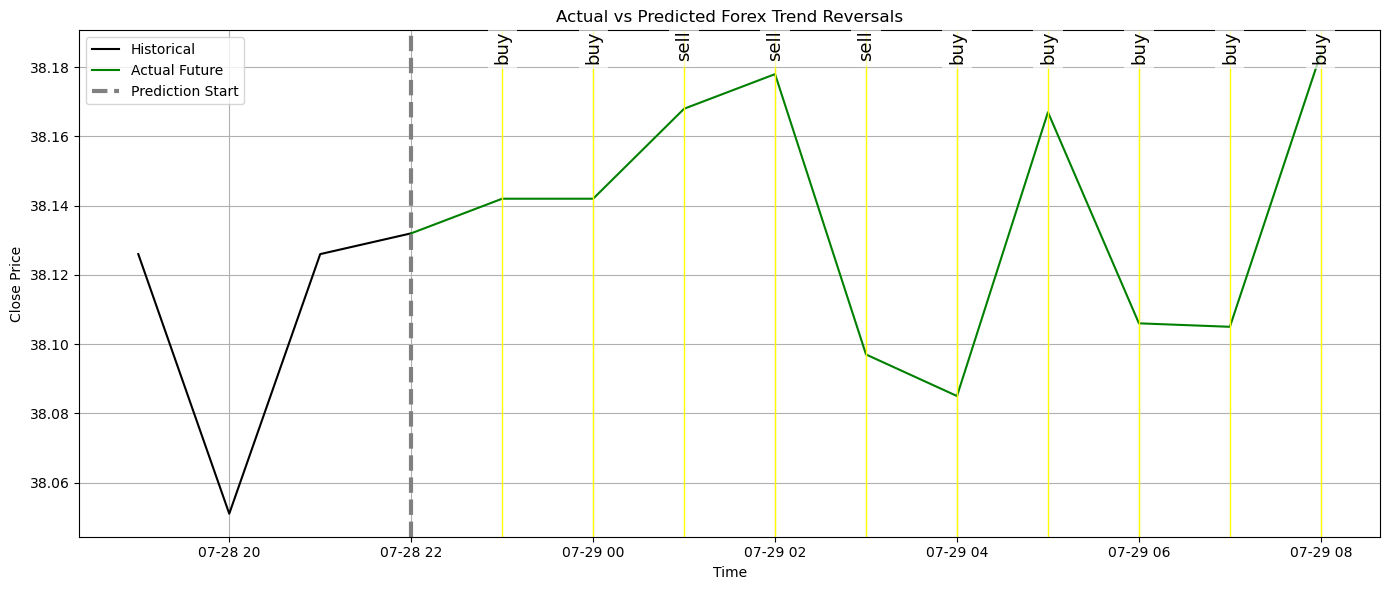

In [27]:
# --- 6. Import your plotting utility ---
sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [16]:
# 11- Save Model

from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
model.save(model_path)

# 11-4 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# 11-5 Save training loss plot
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-6 Save model summary and final performance
y_test_onehot = to_categorical(y_test, num_classes=3)

with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss, final_test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
    f.write(f'Final Test Accuracy: {final_test_accuracy:.6f}\n')

In [ ]:
from tensorflow import keras

model = keras.models.load_model(
    'saved_models/model_20251029_204853.keras',
    safe_mode=False
)
